In [61]:
location = {"lat":6.189, "lon":-67.485, "name":"Puerto Carreño", "year_deterministic":2019}
#location = {"lat":12.583, "lon":-81.706, "name":"San Andrés"}

In [62]:
import pandas as pd
import numpy as np
from utils.functions import extract_tem_min, get_data_fromNSRDB, power_PV_calculation, calculate_WT_power

data_model = {}

data_model["lat"] = location["lat"]
data_model["lon"] = location["lon"]

data_model["interest"] = 0.1
data_model["lifeyears"] = 25

data_model["load"] = {}
data_model["load"]["len"] = 8760
data_model["load"]["value"] = pd.read_csv("CaseData.csv")["LOAD"].to_numpy()
data_model["load"]["reactive"] = False

data_model["pv_modules"] = {}
data_model["pv_modules"]["type"] = pd.read_excel("Catalogo.xlsx", sheet_name = "PVModules", index_col = 0)

Temp_min = extract_tem_min(data_model["lat"], data_model["lon"])
for k in data_model["pv_modules"]["type"].columns:
    data_model["pv_modules"]["type"].loc['Voc_max', k] = np.round(data_model["pv_modules"]["type"].loc['Voc_STC',k]*(1+(data_model["pv_modules"]["type"].loc['Tc_Voc',k]/100)*(Temp_min-25)),2)


data_model["batteries"] = {}
data_model["batteries"]["type"] = pd.read_excel("Catalogo.xlsx", sheet_name = "BattModules", index_col = 0)

data_model["inverters"] = {}
data_model["inverters"]["type"] = pd.read_excel("Catalogo.xlsx", sheet_name = "Hybrid OnGrid", index_col = 0)
data_model["inverters"]["flex"] = False

data_model["windgen"] = {}
data_model["windgen"]["active"] = True
data_model["windgen"]["type"] = pd.read_excel("Catalogo.xlsx", sheet_name = "WindTurbines", index_col = 0)


data_model["ENS"] = {}
data_model["ENS"]["active"] = True
data_model["ENS"]["type"] = "fixed"
data_model["ENS"]["value"] = 16

data_model["grid"] = {}
data_model["grid"]["active"] = True
data_model["grid"]["pmax_buy"] = 200
data_model["grid"]["pmax_sell"] = 20

data_model["grid"]["buy_price"] = {}
data_model["grid"]["buy_price"]["type"] = "variable"
data_model["grid"]["buy_price"]["value"] = pd.read_csv("CaseData.csv")["C_BUY_PC"].to_numpy()

data_model["grid"]["sell_price"] = {}
data_model["grid"]["sell_price"]["type"] = "variable"
data_model["grid"]["sell_price"]["value"] = pd.read_csv("CaseData.csv")["C_SELL_PC"].to_numpy()

data_model["generator"] = {}
data_model["generator"]["active"] = True
data_model["generator"]["fuel_cost"] = 0.59
data_model["generator"]["gen_cost"] = 0
data_model["generator"]["pmax"] = 10
data_model["generator"]["fmin"] = 1
data_model["generator"]["fmax"] = 18 
data_model["generator"]["fm"] = 1.7
data_model["generator"]["gen_OM_cost"] = 1
data_model["generator"]["min_p_load"] = 10

data_model["generator"]["av"] = {}
data_model["generator"]["av"]["active"] = True
data_model["generator"]["av"]["value"] = pd.read_csv("CaseData.csv")["AV_DIESEL"].to_numpy()

data_model["area"] = {}
data_model["area"]["active"] = False

data_model["max_invest"] = {}
data_model["max_invest"]["active"] = False  

data_model["environment"] = {}
data_model["environment"]["active"] = True
data_model["environment"]["mu"] = 266.76
data_model["environment"]["Cbono"] = 4.23

In [63]:
df_pc, info_pc = get_data_fromNSRDB(6.189, -67.485, 2019)
df_sa, info_sa = get_data_fromNSRDB(12.583, -81.706, 2019)

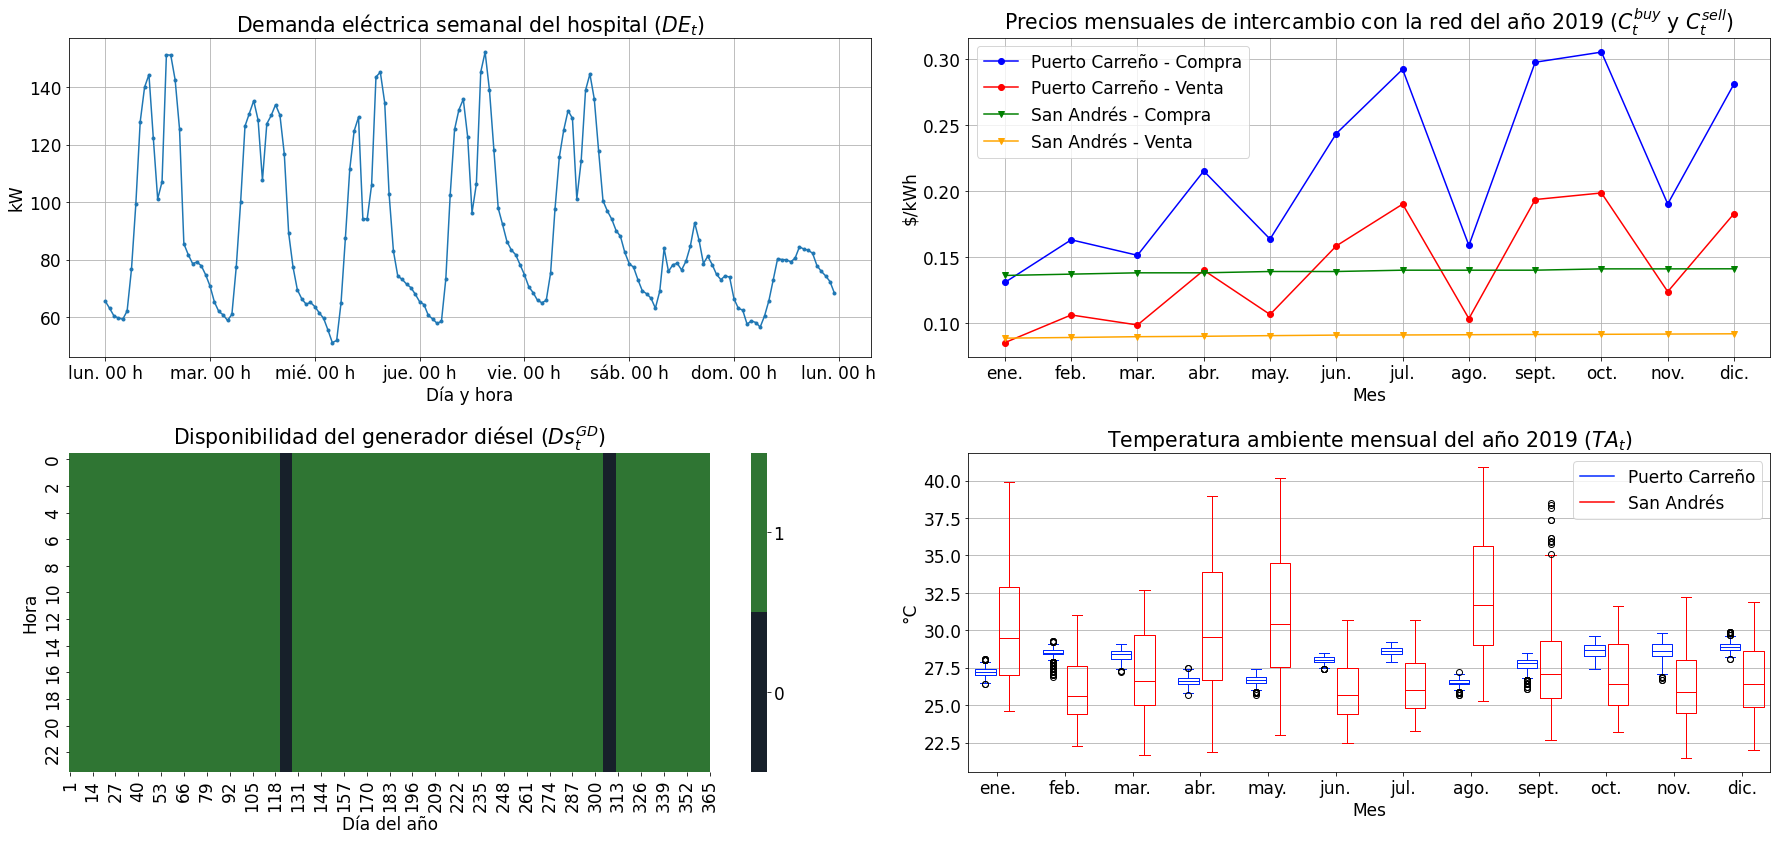

In [71]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import locale
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib
matplotlib.rcParams.update({'font.size': 17})
fechas = pd.date_range(start = '01/01/2019 00:00', end='31/12/2019 23:00', freq='1H')
locale.setlocale(locale.LC_ALL, "es_CO.utf8")

fig, ax = plt.subplots(2, 2, figsize=(25,12))

fig_data = pd.DataFrame(index=fechas, data={"load":data_model["load"]["value"],
                                            "sell_price_pc":data_model["grid"]["sell_price"]["value"],
                                            "buy_price_pc":data_model["grid"]["buy_price"]["value"],
                                            "buy_price_sa":pd.read_csv("CaseData.csv")["C_BUY_SA"].to_numpy(),
                                            "sell_price_sa":pd.read_csv("CaseData.csv")["C_SELL_SA"].to_numpy(),
                                            "av_diesel":data_model["generator"]["av"]["value"],
                                            "temperature_pc":df_pc["Temperature"].to_numpy(),
                                            "temperature_sa":df_sa["Temperature"].to_numpy()})
fig_data["day_year"] = fig_data.index.day_of_year
fig_data["month"] = fig_data.index.strftime("%b")
fig_data["month_number"] = fig_data.index.month
fig_data["hour"] = fig_data.index.hour

ax[0,0].plot(fig_data.index.to_series().loc['2019-01-07 00:00':'2019-01-13 23:00'],fig_data.loc['2019-01-07 00:00':'2019-01-13 23:00',"load"], marker = 'o', ms = 3)
date_form = DateFormatter("%a %H h")

ax[0,0].xaxis.set_major_formatter(date_form)
ax[0,0].set_title("Demanda eléctrica semanal del hospital ($DE_t$)")
ax[0,0].set_xlabel("Día y hora")
ax[0,0].set_ylabel("kW")
ax[0,0].grid()


fig_price = fig_data.groupby(by=["month"]).mean().sort_values("month_number")
ax[0,1].plot(fig_price.index , fig_price.buy_price_pc, marker = 'o', c='b')
ax[0,1].plot(fig_price.index , fig_price.sell_price_pc, marker = 'o', c='r')
ax[0,1].plot(fig_price.index , fig_price.buy_price_sa, marker = 'v', c='g')
ax[0,1].plot(fig_price.index , fig_price.sell_price_sa, marker = 'v', c='orange')
ax[0,1].set_title("Precios mensuales de intercambio con la red del año 2019 ($C^{buy}_{t}$ y $C^{sell}_{t}$)")
ax[0,1].set_xlabel("Mes")
ax[0,1].set_ylabel("$/kWh")
ax[0,1].grid()
ax[0,1].legend(["Puerto Carreño - Compra", "Puerto Carreño - Venta", "San Andrés - Compra", "San Andrés - Venta"])


myColors = ((23/255, 32/255, 42/255, 1.0), (47/255, 117/255, 51/255, 1.0))
cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))
sns.heatmap(fig_data.pivot(index="hour", columns="day_year", values="av_diesel"), ax = ax[1,0],  cmap=cmap, vmin = 0, vmax = 1, linewidths=0.0, rasterized=True)

ax[1,0].set_xlabel("Día del año")
ax[1,0].set_ylabel("Hora")
colorbar = ax[1,0].collections[0].colorbar
colorbar.set_ticks([0.25,0.75])
colorbar.set_ticklabels([0,1])
#for i in range(fig_data.pivot(index="hour", columns="day_year", values="av_diesel").to_numpy().shape[1]+1):
#    ax[1,0].axvline(i, color='white', lw=0.001)
#for i in range(fig_data.pivot(index="hour", columns="day_year", values="av_diesel").to_numpy().shape[0]+1):
#    ax[1,0].axhline(i, color='white', lw=0.001)
ax[1,0].set_title("Disponibilidad del generador diésel ($Ds^{GD}_{t}$)")

#ax[1,0].tick_params(axis='both', labelsize=11)

temp_pc_fig = [fig_data.loc[fig_data.month == i,"temperature_sa"].to_numpy() for i in np.unique(fig_data.month.to_numpy())]
temp_sa_fig = [fig_data.loc[fig_data.month == i,"temperature_pc"].to_numpy() for i in np.unique(fig_data.month.to_numpy())]

temp_pc_plot = ax[1,1].boxplot(temp_pc_fig, positions=np.array(np.arange(len(temp_pc_fig)))*2.0-0.35, widths=0.6)
temp_sa_plot = ax[1,1].boxplot(temp_sa_fig, positions=np.array(np.arange(len(temp_sa_fig)))*2.0+0.35, widths=0.6)

def define_box_properties(plot_name, color_code, label):
    for k, v in plot_name.items():
        plt.setp(plot_name.get(k), color=color_code)
        
    # use plot function to draw a small line to name the legend.
    ax[1,1].plot([], c=color_code, label=label)
    ax[1,1].legend()

define_box_properties(temp_pc_plot, '#0027FF', 'Puerto Carreño')
define_box_properties(temp_sa_plot, '#FF0000', 'San Andrés')

a = fig_data.month.to_numpy()
indexes = np.unique(a, return_index=True)[1]
ticks = [a[index] for index in sorted(indexes)]
ax[1,1].set_xticks(np.arange(0, len(ticks) * 2, 2), ticks)
ax[1,1].set_title("Temperatura ambiente mensual del año 2019 ($TA_{t}$)")
ax[1,1].set_xlabel("Mes")
ax[1,1].set_ylabel("°C")
ax[1,1].grid(axis='y')
fig.tight_layout()
plt.savefig('series_params.pdf', format='pdf', transparent=True)
plt.show()

In [63]:
from datetime import datetime
from utils.functions import extract_tem_min, get_data_fromNSRDB, power_PV_calculation, calculate_WT_power

def extract_dfs(lat, lon):
    df = pd.DataFrame()
    
    for i in [2015,2016,2017,2018,2019,2020]:
        df1, info1 = get_data_fromNSRDB(lat, lon, i)
        
        df = pd.concat([df, df1])

    date_vec = np.vectorize(datetime)
    df_index = date_vec(df.Year.values,df.Month.values,df.Day.values, df.Hour.values, df.Minute.values, tzinfo=None)
    df.index = df_index

    return df

df_pc = extract_dfs(6.189, -67.485)
df_sa = extract_dfs(12.583, -81.706)

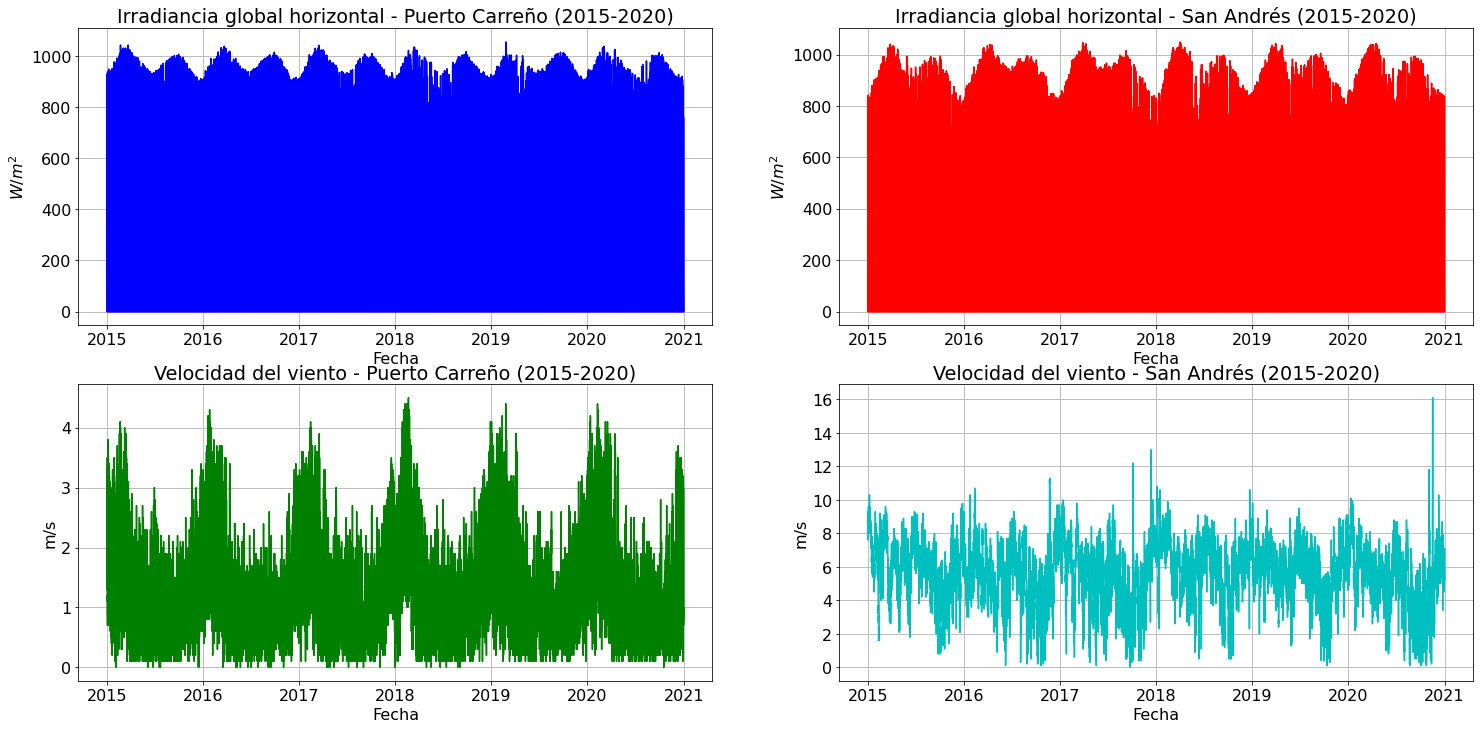

In [64]:

fig, ax = plt.subplots(2, 2, figsize=(25,12))


ax[0,0].plot(df_pc.index,df_pc["GHI"], c='b')
#date_form = DateFormatter("%a %H h")
#locale.setlocale(locale.LC_ALL, "es_CO.utf8")
#ax[0,0].xaxis.set_major_formatter(date_form)
ax[0,0].set_title("Irradiancia global horizontal - Puerto Carreño (2015-2020)")
ax[0,0].set_xlabel("Fecha")
ax[0,0].set_ylabel("$W/m^2$")
ax[0,0].grid()


ax[0,1].plot(df_sa.index,df_sa["GHI"], 'r')
#date_form = DateFormatter("%a %H h")
#locale.setlocale(locale.LC_ALL, "es_CO.utf8")
#ax[0,0].xaxis.set_major_formatter(date_form)
ax[0,1].set_title("Irradiancia global horizontal - San Andrés (2015-2020)")
ax[0,1].set_xlabel("Fecha")
ax[0,1].set_ylabel("$W/m^2$")
ax[0,1].grid()

ax[1,0].plot(df_pc.index,df_pc["Wind Speed"], 'g')
#date_form = DateFormatter("%a %H h")
#locale.setlocale(locale.LC_ALL, "es_CO.utf8")
#ax[0,0].xaxis.set_major_formatter(date_form)
ax[1,0].set_title("Velocidad del viento - Puerto Carreño (2015-2020)")
ax[1,0].set_xlabel("Fecha")
ax[1,0].set_ylabel("m/s")
ax[1,0].grid()

ax[1,1].plot(df_sa.index,df_sa["Wind Speed"], 'c')
#date_form = DateFormatter("%a %H h")
#locale.setlocale(locale.LC_ALL, "es_CO.utf8")
#ax[0,0].xaxis.set_major_formatter(date_form)
ax[1,1].set_title("Velocidad del viento - San Andrés (2015-2020)")
ax[1,1].set_xlabel("Fecha")
ax[1,1].set_ylabel("m/s")
ax[1,1].grid()


In [59]:
import pandas as pd

GHI_scens_pc = pd.read_csv(f'Escenarios/GHI_scens_PC.csv')
wind_scens_pc = pd.read_csv(f'Escenarios/wind_scens_PC.csv')

GHI_scens_sa = pd.read_csv(f'Escenarios/GHI_scens_SA.csv')
wind_scens_sa = pd.read_csv(f'Escenarios/wind_scens_SA.csv')


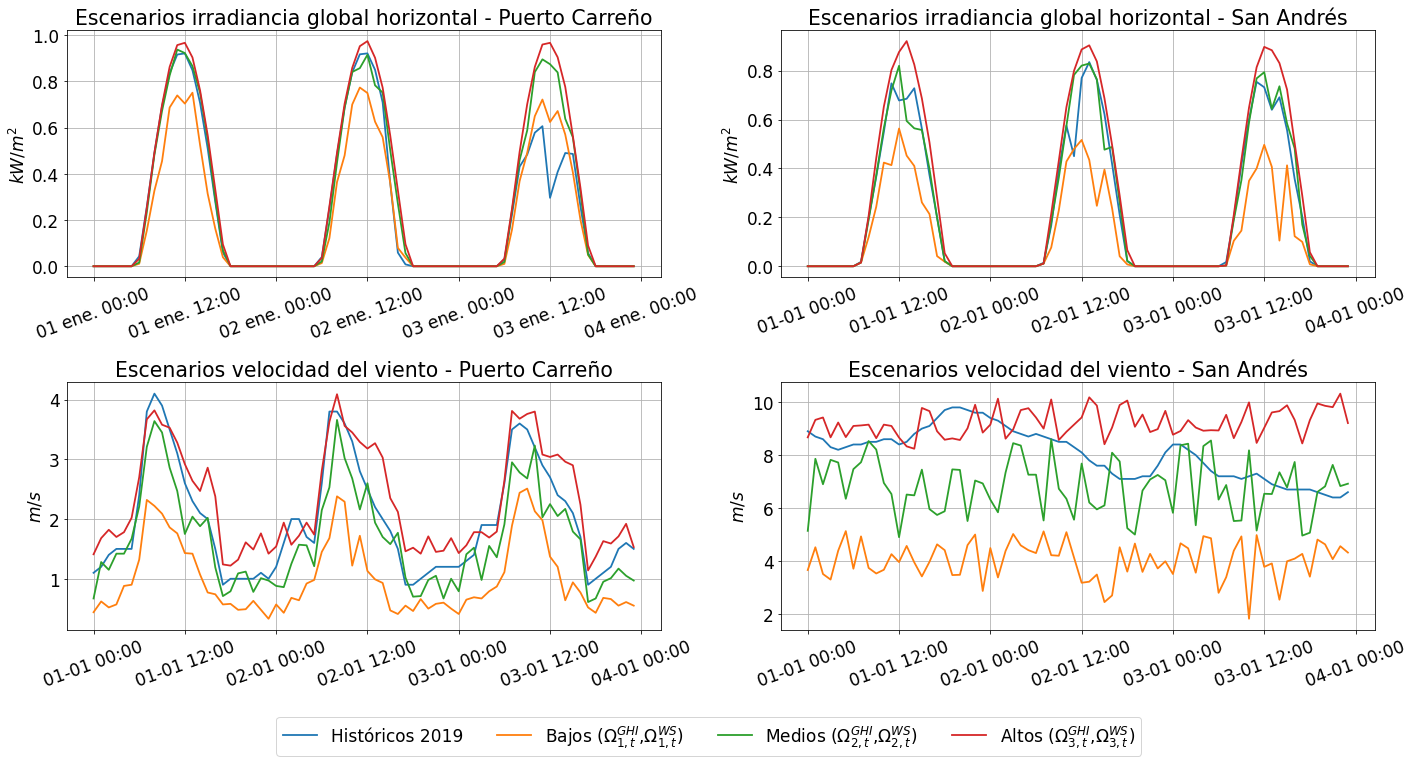

In [81]:
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 17})

fig, ax = plt.subplots(2, 2, figsize=(20,10))

lw = 1.8

df_pc = df_pc.loc[df_pc["Year"] == 2019, :]
df_sa = df_sa.loc[df_sa["Year"] == 2019, :]

lim1, lim2 = 24*0, 24*3

legend_labels = ["Históricos 2019", r'Bajos ($\Omega^{GHI}_{1,t}$,$\Omega^{WS}_{1,t}$)', r'Medios ($\Omega^{GHI}_{2,t}$,$\Omega^{WS}_{2,t}$)', r'Altos ($\Omega^{GHI}_{3,t}$,$\Omega^{WS}_{3,t}$)']


ax[0,0].plot(df_pc.index[lim1:lim2],df_pc["GHI"][lim1:lim2]/1000, linewidth=lw, label=legend_labels[0])
for k, i in enumerate(GHI_scens_pc.columns):
    ax[0,0].plot(df_pc.index[lim1:lim2],GHI_scens_pc[i][lim1:lim2]/1000, linewidth=lw, label=legend_labels[k+1])
date_form = DateFormatter("%d %b %H:00")
locale.setlocale(locale.LC_ALL, "es_CO.utf8")
ax[0,0].xaxis.set_major_formatter(date_form)
ax[0,0].set_title("Escenarios irradiancia global horizontal - Puerto Carreño")

ax[0,0].set_ylabel("$kW/m^2$")
ax[0,0].grid()
ax[0,0].tick_params(axis='x', labelrotation = 20)

ax[0,1].plot(df_sa.index[lim1:lim2],df_sa["GHI"][lim1:lim2]/1000, linewidth=lw, label=legend_labels[0])
for k, i in enumerate(GHI_scens_pc.columns):
    ax[0,1].plot(df_sa.index[lim1:lim2],GHI_scens_sa[i][lim1:lim2]/1000, linewidth=lw, label=legend_labels[k+1])
date_form = DateFormatter("%d-%m %H:00")
locale.setlocale(locale.LC_ALL, "es_CO.utf8")
ax[0,1].xaxis.set_major_formatter(date_form)
ax[0,1].set_title("Escenarios irradiancia global horizontal - San Andrés")

ax[0,1].set_ylabel("$kW/m^2$")
ax[0,1].grid()
ax[0,1].tick_params(axis='x', labelrotation = 20)

ax[1,0].plot(df_pc.index[lim1:lim2],df_pc["Wind Speed"][lim1:lim2], linewidth=lw, label=legend_labels[0])
for k,i in enumerate(wind_scens_pc.columns):
    ax[1,0].plot(df_pc.index[lim1:lim2],wind_scens_pc[i][lim1:lim2], linewidth=lw, label=legend_labels[k+1])
date_form = DateFormatter("%d-%m %H:00")
locale.setlocale(locale.LC_ALL, "es_CO.utf8")
ax[1,0].xaxis.set_major_formatter(date_form)
ax[1,0].set_title("Escenarios velocidad del viento - Puerto Carreño")

ax[1,0].set_ylabel("$m/s$")
ax[1,0].grid()
ax[1,0].tick_params(axis='x', labelrotation = 20)

ax[1,1].plot(df_sa.index[lim1:lim2],df_sa["Wind Speed"][lim1:lim2], linewidth=lw, label=legend_labels[0])
for k,i in enumerate(wind_scens_sa.columns):
    ax[1,1].plot(df_sa.index[lim1:lim2],wind_scens_sa[i][lim1:lim2], linewidth=lw, label=legend_labels[k+1])
date_form = DateFormatter("%d-%m %H:00")
locale.setlocale(locale.LC_ALL, "es_CO.utf8")
ax[1,1].xaxis.set_major_formatter(date_form)
ax[1,1].set_title("Escenarios velocidad del viento - San Andrés")

ax[1,1].set_ylabel("$m/s$")
ax[1,1].grid()

ax[1,1].tick_params(axis='x', labelrotation = 20)


labels_handles = {
  label: handle for ax in fig.axes for handle, label in zip(*ax.get_legend_handles_labels())
}


lgd = fig.legend(
  labels_handles.values(),
  labels_handles.keys(),
  loc = "upper center",
  bbox_to_anchor = (0.5, 0),
  bbox_transform = plt.gcf().transFigure,
  ncol=4
)

fig.tight_layout()


plt.savefig('meteo_scens1.pdf', format='pdf', bbox_inches='tight')
plt.show()

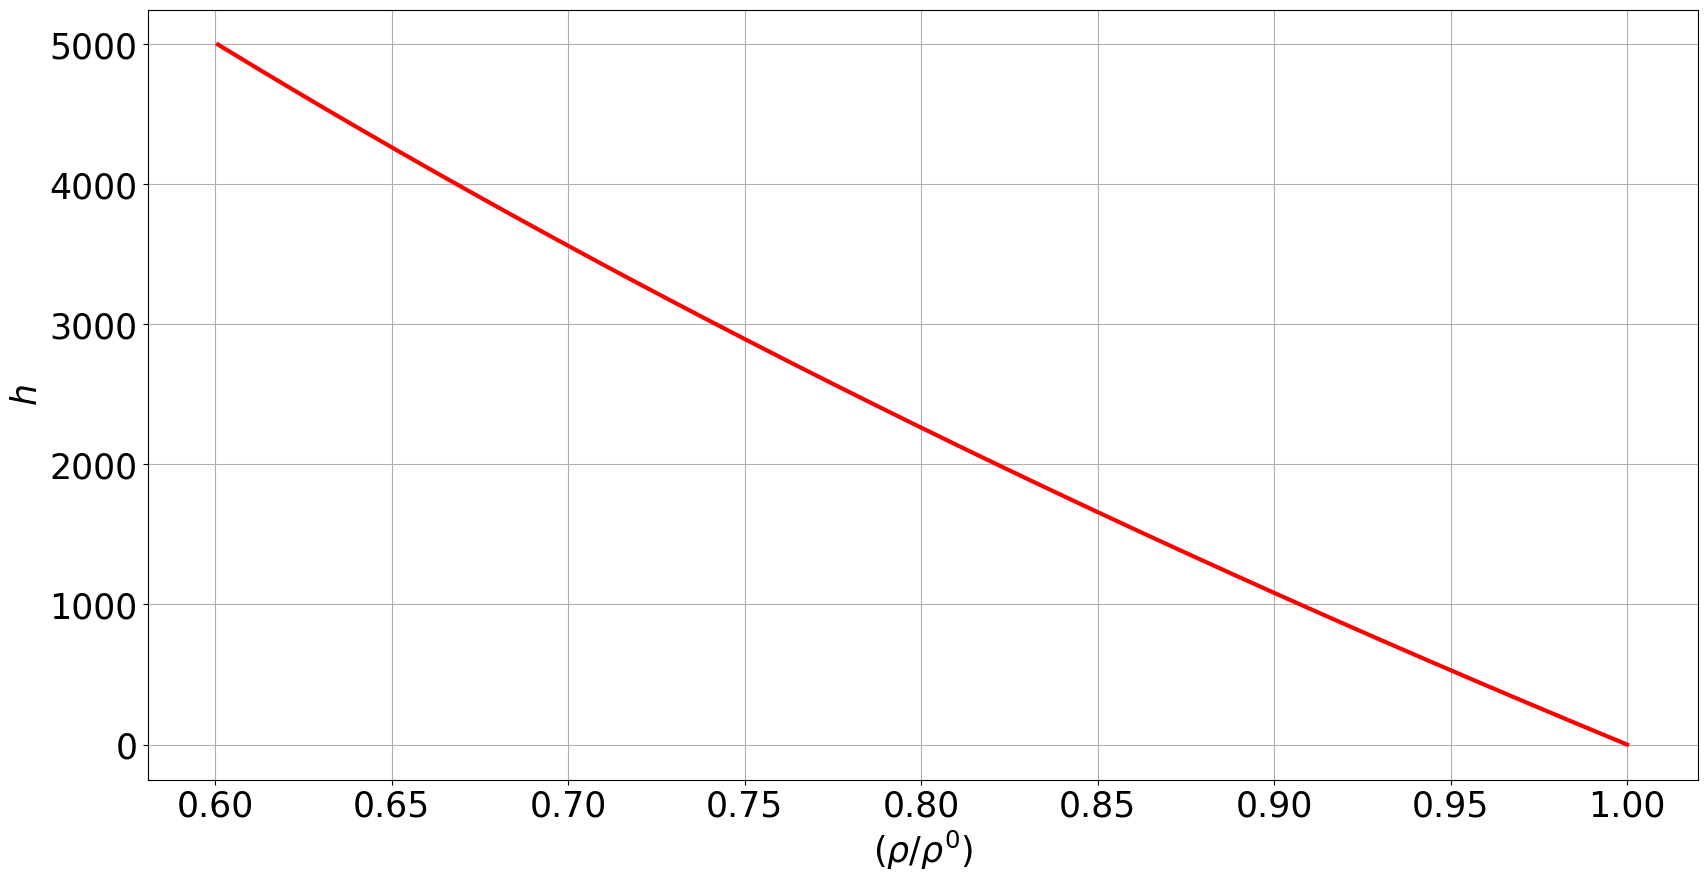

In [4]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

matplotlib.rcParams.update({'font.size': 25})

elevation = np.arange(0,5000,1)
coef_den = ((1-(0.0065*elevation)/288.16)**(9.81/(287*0.0065)))*(288.16/(288.16-0.0065*elevation)) 

fig = plt.figure(figsize=(20,10))
plt.plot(coef_den, elevation, linewidth = 3, c='r')
plt.xlabel(r'($\rho/\rho^0$)')
plt.ylabel("$h$")
plt.grid()

plt.savefig('Figuras/pdf/coef_density.pdf', format='pdf', transparent=True)
plt.show()


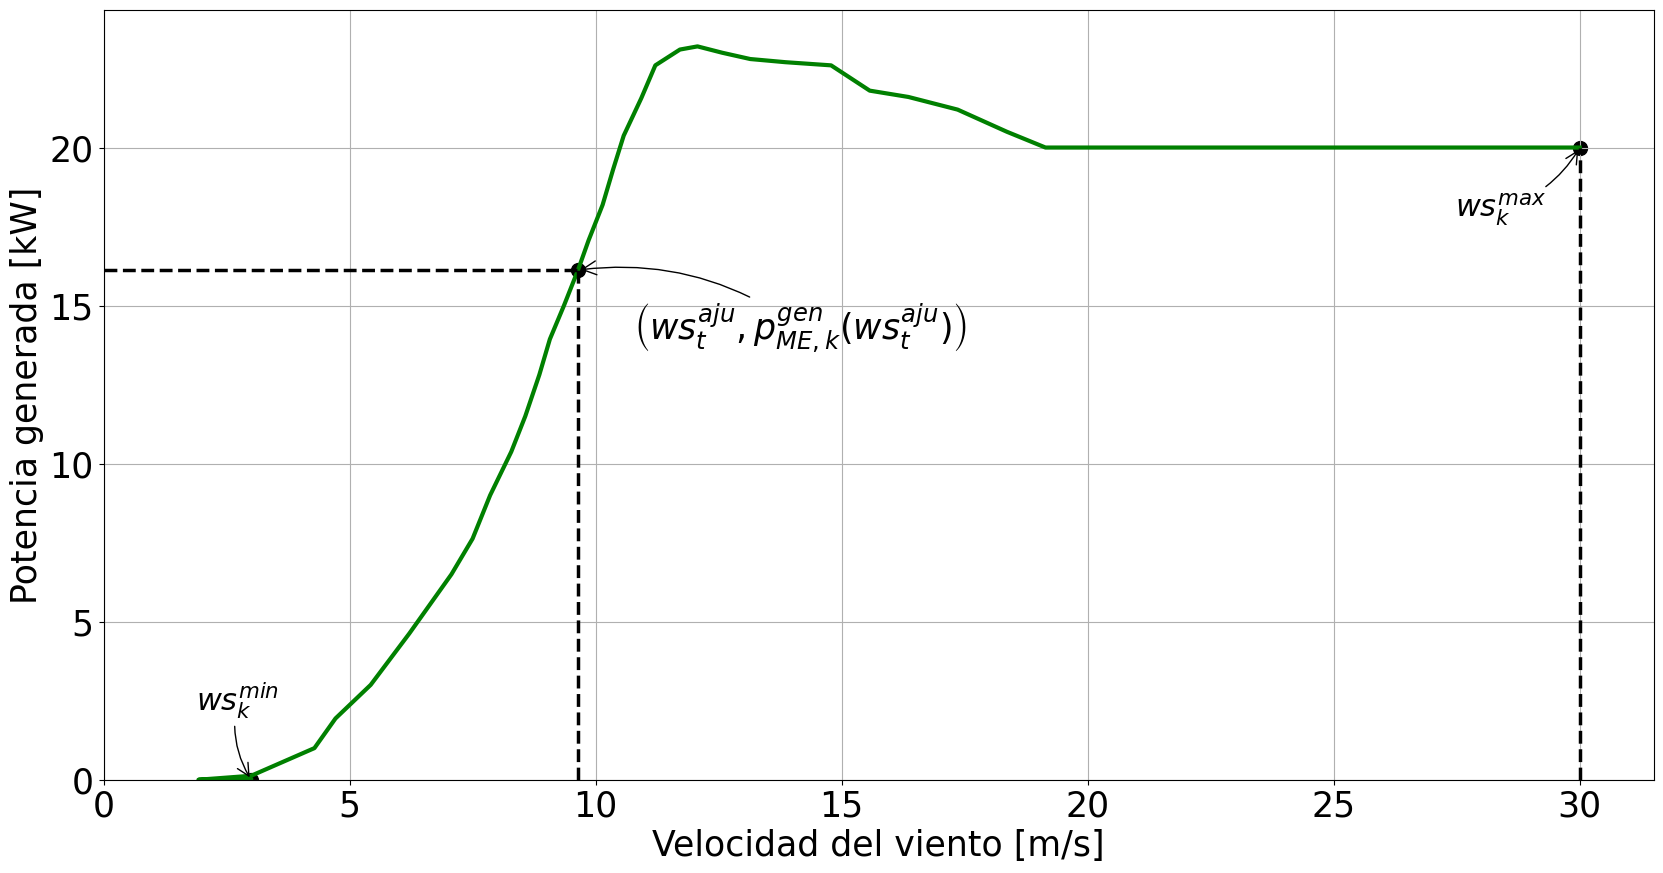

In [2]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

matplotlib.rcParams.update({'font.size': 25})

profile = pd.read_excel('Catalogo.xlsx',sheet_name = "FX-20kW",header=0)
profile.loc[0] = [3,0] 
profile.loc[len(profile)] = [30,20] 
fig = plt.figure(figsize=(20,10))
plt.plot(profile["wind_speed"], profile["power"], linewidth = 3, c='g')
plt.xlabel("Velocidad del viento [m/s]")
plt.ylabel("Potencia generada [kW]")
plt.grid()



plt.plot([30, 30], [0, 20], color='k', linewidth=2.5, linestyle="--")
plt.scatter([30, ], [20, ], 100, color='k')
plt.annotate(r'$ws^{max}_{k}$',
            xy=(30, 20), xycoords='data',
            xytext=(-90, -50), textcoords='offset points', fontsize=22,
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))



plt.scatter([3, ], [0, ], 100, color='k')
plt.annotate(r'$ws^{min}_{k}$',
            xy=(3, 0), xycoords='data',
            xytext=(-40, +50), textcoords='offset points', fontsize=22,
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))

point = profile.iloc[15].to_numpy()

plt.plot([point[0], point[0]], [0, point[1]], color='k', linewidth=2.5, linestyle="--")
plt.plot([0, point[0]], [point[1], point[1]], color='k', linewidth=2.5, linestyle="--")
plt.scatter([point[0], ], [point[1], ], 100, color='k')
plt.annotate(r'$\left(ws^{aju}_{t},p^{gen}_{ME,k}(ws^{aju}_{t}) \right)$',
            xy=(point[0], point[1]), xycoords='data',
            xytext=(+40, -50), textcoords='offset points', fontsize=25,
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))


plt.xlim(left=0)
plt.ylim(bottom=0)
plt.savefig('Figuras/pdf/profile_power.pdf', format='pdf', transparent=True)
plt.show()







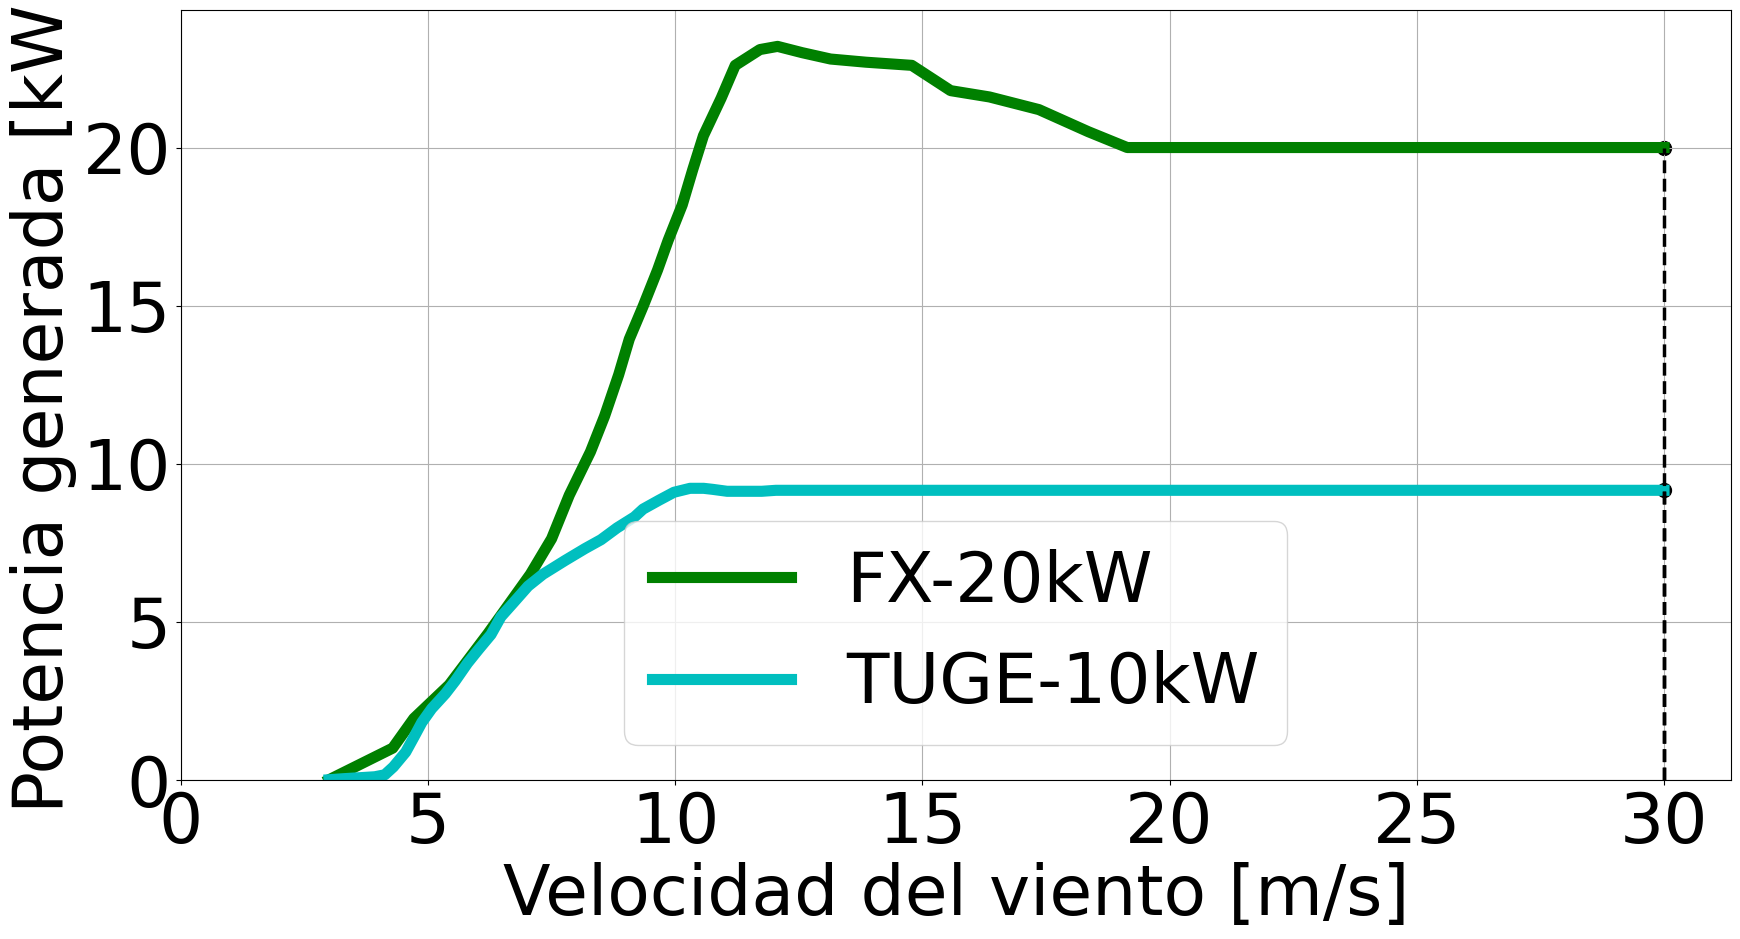

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 50})

fig = plt.figure(figsize=(20,10))

profile = pd.read_excel('Catalogo.xlsx',sheet_name = "FX-20kW",header=0)
profile = profile.iloc[2:,:]
profile.iloc[0] = [3,0] 
profile = pd.concat([profile, pd.DataFrame(data={"wind_speed":[30], "power":profile.iloc[-1,1]})])

plt.plot(profile["wind_speed"], profile["power"], linewidth = 8, c='g')

profile = pd.read_excel('Catalogo.xlsx',sheet_name = "TUGE-10kW",header=0)
profile.loc[0] = [3,0] 
profile.loc[len(profile)] = [30,profile.iloc[-1,1]] 
plt.plot(profile["wind_speed"], profile["power"], linewidth = 8, c='c')

plt.xlabel("Velocidad del viento [m/s]")
plt.ylabel("Potencia generada [kW]")
plt.grid()
plt.legend(["FX-20kW", "TUGE-10kW"])


profile = pd.read_excel('Catalogo.xlsx',sheet_name = "FX-20kW",header=0)
profile = profile.iloc[2:,:]
profile.iloc[0] = [3,0] 
profile = pd.concat([profile, pd.DataFrame(data={"wind_speed":[30], "power":profile.iloc[-1,1]})])
point = profile.iloc[-1].to_numpy()
plt.plot([point[0], point[0]], [0, point[1]], color='k', linewidth=2.5, linestyle="--")
plt.scatter([point[0], ], [point[1], ], 100, color='k')

profile = pd.read_excel('Catalogo.xlsx',sheet_name = "TUGE-10kW",header=0)
profile.loc[0] = [3,0] 
profile.loc[len(profile)] = [30,profile.iloc[-1,1]] 
point = profile.iloc[-1].to_numpy()
plt.plot([point[0], point[0]], [0, point[1]], color='k', linewidth=2.5, linestyle="--")
plt.scatter([point[0], ], [point[1], ], 100, color='k')


plt.xlim(left=0)
plt.ylim(bottom=0)
plt.savefig('Figuras/pdf/profiles.pdf', format='pdf', transparent=True, bbox_inches="tight", pad_inches=1)
plt.show()


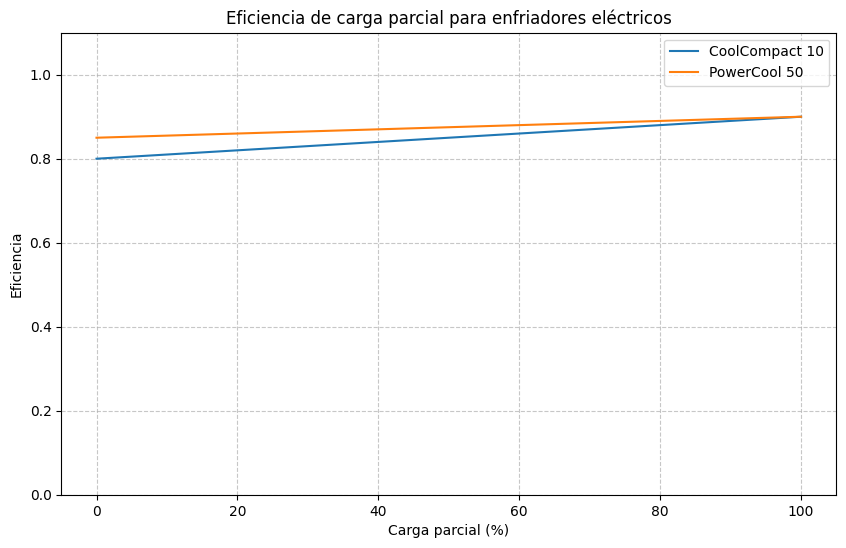

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros de eficiencia de carga parcial para ambas tecnologías
technologies = {
    "CoolCompact 10": {"y_n": 0.8, "lambd_n": 0.1},
    "PowerCool 50": {"y_n": 0.85, "lambd_n": 0.05}
}

# Rango de carga parcial (0% a 100%)
partial_load = np.linspace(0, 1, 100)

# Cálculo de la eficiencia para cada tecnología
efficiency_data = {}
for name, params in technologies.items():
    y_n = params["y_n"]
    lambd_n = params["lambd_n"]
    efficiency_data[name] = y_n + lambd_n * partial_load

# Gráfica de las eficiencias
plt.figure(figsize=(10, 6))
for name, efficiency in efficiency_data.items():
    plt.plot(partial_load * 100, efficiency, label=name)

# Configuración de la gráfica
plt.title("Eficiencia de carga parcial para enfriadores eléctricos")
plt.xlabel("Carga parcial (%)")
plt.ylabel("Eficiencia")
plt.ylim(0, 1.1)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()
plt.show()


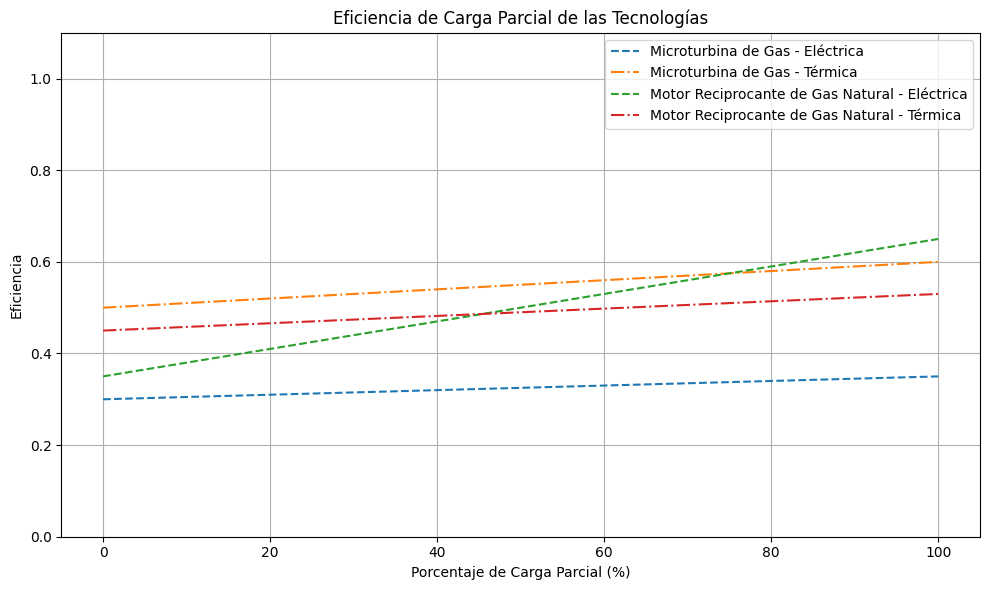

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros de la Tecnología 1 (Microturbina de Gas)
tech1 = {
    "name": "Microturbina de Gas",
    "y_n_el": 0.25,
    "lambda_n_el": 0.75,
    "y_n_th": 0.40,
    "lambda_n_th": 0.60
}

# Parámetros de la Tecnología 2 (Motor Reciprocante de Gas Natural)
tech2 = {
    "name": "Motor Reciprocante de Gas Natural",
    "y_n_el": 0.30,
    "lambda_n_el": 0.65,
    "y_n_th": 0.45,
    "lambda_n_th": 0.50
}

# Porcentajes de carga parcial (de 0% a 100%)
load_percentages = np.linspace(0, 1, 100)

# Función para calcular la eficiencia eléctrica y térmica
def calculate_efficiency(y_n, lambda_n, load):
    return y_n + lambda_n * load

# Cálculo de eficiencias
eff_tech1_el = calculate_efficiency(tech1["y_n_el"], tech1["lambda_n_el"], load_percentages)
eff_tech1_th = calculate_efficiency(tech1["y_n_th"], tech1["lambda_n_th"], load_percentages)
eff_tech2_el = calculate_efficiency(tech2["y_n_el"], tech2["lambda_n_el"], load_percentages)
eff_tech2_th = calculate_efficiency(tech2["y_n_th"], tech2["lambda_n_th"], load_percentages)

# Gráfica
plt.figure(figsize=(10, 6))

# Tecnología 1
plt.plot(load_percentages * 100, eff_tech1_el, label=f"{tech1['name']} - Eléctrica", linestyle='--')
plt.plot(load_percentages * 100, eff_tech1_th, label=f"{tech1['name']} - Térmica", linestyle='-.')

# Tecnología 2
plt.plot(load_percentages * 100, eff_tech2_el, label=f"{tech2['name']} - Eléctrica", linestyle='--')
plt.plot(load_percentages * 100, eff_tech2_th, label=f"{tech2['name']} - Térmica", linestyle='-.')

# Personalización de la gráfica
plt.title("Eficiencia de Carga Parcial de las Tecnologías")
plt.xlabel("Porcentaje de Carga Parcial (%)")
plt.ylabel("Eficiencia")
plt.legend()
plt.grid(True)
plt.ylim(0, 1.1)
plt.tight_layout()

# Mostrar la gráfica
plt.show()


In [23]:
import plotly.graph_objects as go

data_fig = [go.Scatter(y=df_pc.loc[df_pc["Year"] == 2019, "GHI"].to_numpy(), name='Históricos de 2019')]
data_fig.extend([go.Scatter(y=GHI_scens_pc[key], name=f'{key}') for key in GHI_scens_pc.columns])

fig = go.Figure(data=data_fig)
fig.update_layout(title="Escenarios irradiancia global horizontal - Puerto Carreño", xaxis_title="Hora del año", yaxis_title="W/m^2", font=dict(size=14))
fig.show()

In [1]:
from utils.functions import createfig_heatmap
import pandas as pd


av_scens = pd.read_csv(f'Escenarios/av_scens_PC.csv')

fig = createfig_heatmap(av_scens, "scen1", True, '[1,0]', "Escenario 1")

fig.save('scen1.html')
fig




alt.Chart(...)

In [2]:
fig = createfig_heatmap(av_scens, "scen2", True, '[1,0]', "Escenario 2")
fig.save('scen2.html')
fig


alt.Chart(...)

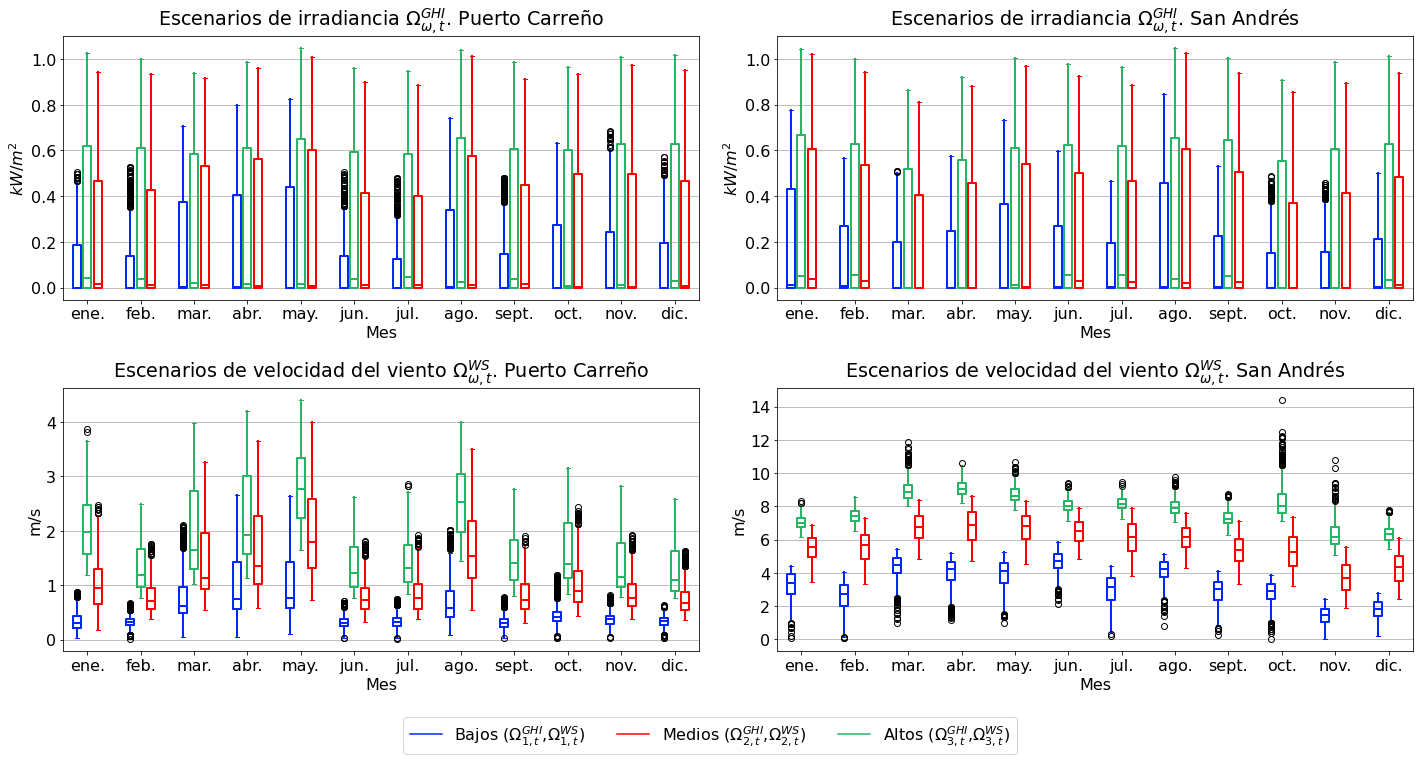

In [58]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import locale
import matplotlib
import numpy as np
import pandas as pd
matplotlib.rcParams.update({'font.size': 16})
fechas = pd.date_range(start = '01/01/2019 00:00', end='31/12/2019 23:00', freq='1H')
locale.setlocale(locale.LC_ALL, "es_CO.utf8")

def create_ax_scen(fig_data,ax,unit):
    bad = [fig_data.loc[fig_data.month == i,"bad"].to_numpy() for i in np.unique(fig_data.month.to_numpy())]
    mean = [fig_data.loc[fig_data.month == i,"mean"].to_numpy() for i in np.unique(fig_data.month.to_numpy())]
    good = [fig_data.loc[fig_data.month == i,"good"].to_numpy() for i in np.unique(fig_data.month.to_numpy())]

    bad_plot = ax.boxplot(bad, positions=np.array(np.arange(len(bad)))*2.0-0.4, widths=0.3, whiskerprops = dict(linewidth=2.0), boxprops= dict(linewidth=2.0), medianprops=dict(linewidth=2.0))
    mean_plot = ax.boxplot(mean, positions=np.array(np.arange(len(mean)))*2.0+0.4, widths=0.3, whiskerprops = dict(linewidth=2.0), boxprops= dict(linewidth=2.0), medianprops=dict(linewidth=2.0))
    good_plot = ax.boxplot(good, positions=np.array(np.arange(len(good)))*2.0, widths=0.3, whiskerprops = dict(linewidth=2.0), boxprops= dict(linewidth=2.0), medianprops=dict(linewidth=2.0))

    def define_box_properties(plot_name, color_code, label):
        for k, v in plot_name.items():
            plt.setp(plot_name.get(k), color=color_code)
            
        # use plot function to draw a small line to name the legend.
        ax.plot([], c=color_code, label=label)
        #ax.legend()

    define_box_properties(bad_plot, '#0027FF', r'Bajos ($\Omega^{GHI}_{1,t}$,$\Omega^{WS}_{1,t}$)')
    define_box_properties(mean_plot, '#FF0000', r'Medios ($\Omega^{GHI}_{2,t}$,$\Omega^{WS}_{2,t}$)')
    define_box_properties(good_plot, '#28B463', r'Altos ($\Omega^{GHI}_{3,t}$,$\Omega^{WS}_{3,t}$)')

    a = fig_data.month.to_numpy()
    indexes = np.unique(a, return_index=True)[1]
    ticks = [a[index] for index in sorted(indexes)]
    ax.set_xticks(np.arange(0, len(ticks) * 2, 2), ticks)
    ax.set_xlabel("Mes")
    ax.set_ylabel(unit)
    ax.grid(axis='y')


fig, ax = plt.subplots(2,2,figsize=(20,10))


fig_data = (pd.read_csv(f'Escenarios/GHI_scens_PC.csv')/1000)
fig_data.index = fechas
fig_data["month"] = fig_data.index.strftime("%b")
create_ax_scen(fig_data,ax[0,0],'$kW/m^2$')
ax[0,0].set_title(f'Escenarios de irradiancia ' + r'$\Omega^{GHI}_{\omega,t}$' + '. Puerto Carreño')
#ax[0,0].set_ylim(top=1.3)
#ax[0,0].legend(prop={'size': 15})


fig_data = (pd.read_csv(f'Escenarios/GHI_scens_SA.csv')/1000)
fig_data.index = fechas
fig_data["month"] = fig_data.index.strftime("%b")
create_ax_scen(fig_data,ax[0,1],'$kW/m^2$')
ax[0,1].set_title(f'Escenarios de irradiancia ' + r'$\Omega^{GHI}_{\omega,t}$' + '. San Andrés')
#ax[0,1].set_ylim(top=1.3)
#ax[0,0].legend(prop={'size': 15})


fig_data = pd.read_csv(f'Escenarios/wind_scens_PC.csv')
fig_data.index = fechas
fig_data["month"] = fig_data.index.strftime("%b")
create_ax_scen(fig_data,ax[1,0],'m/s')
ax[1,0].set_title(f'Escenarios de velocidad del viento ' + r'$\Omega^{WS}_{\omega,t}$' + '. Puerto Carreño')



fig_data = pd.read_csv(f'Escenarios/wind_scens_SA.csv')
fig_data.index = fechas
fig_data["month"] = fig_data.index.strftime("%b")
create_ax_scen(fig_data,ax[1,1],'m/s')
ax[1,1].set_title(f'Escenarios de velocidad del viento ' + r'$\Omega^{WS}_{\omega,t}$' + '. San Andrés')





labels_handles = {
  label: handle for ax in fig.axes for handle, label in zip(*ax.get_legend_handles_labels())
}

lgd = fig.legend(
  labels_handles.values(),
  labels_handles.keys(),
  loc = "upper center",
  bbox_to_anchor = (0.5, 0),
  bbox_transform = plt.gcf().transFigure,
  ncol=3
)

fig.tight_layout()


plt.savefig('meteo_scens.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [5]:
import folium
from folium.features import DivIcon

a = """font-family: Georgia;
font-size: 19px;
font-style: normal;
font-weight: bold;
text-decoration: none;
text-transform: none;
color: #000000;
font-variant: small-caps;
"""




m = folium.Map(location=[5.1261, -70.8755], zoom_start=8, tiles = 'cartodbpositron')

['stamenwatercolor', 'cartodbpositron', 'openstreetmap', 'stamenterrain']

folium.Marker(
    location=[5.1261, -70.8755],    
).add_to(m)

folium.Marker(
    location=[4.433, -69.8],
).add_to(m)

folium.Marker(
    location=[6.19031, -67.4837],
).add_to(m)


folium.map.Marker(
    [5.1261, -70.8755],
    icon=DivIcon(
        icon_size=(200,10),
        icon_anchor=(0,0),
        html=f'<div style="{a}";class="container"><p>Santa Rosalía</p></div>',
        )
    ).add_to(m)


folium.map.Marker(
    [4.433, -69.8],
    icon=DivIcon(
        icon_size=(200,10),
        icon_anchor=(0,0),
        html=f'<div style="{a}";class="container"><p>Cumaribo</p></div>',
        )
    ).add_to(m)

folium.map.Marker(
    [6.19031, -67.4837],
    icon=DivIcon(
        icon_size=(200,10),
        icon_anchor=(0,0),
        html=f'<div style="{a}";class="container"><p>Puerto Carreño</p></div>',
        )
    ).add_to(m)

m.save("Figuras/mapa.html")

m

In [2]:
9600+9040+26400+42000+42900+48500+5540+8362


192342

In [80]:
import pandas as pd

diesel = pd.read_csv("CaseData.csv")
av_scens = pd.read_csv("Escenarios/av_scens_PC.csv")

cont = 1
for i in range(0,len(diesel)):
    if (not diesel.loc[i,"AV_DIESEL"]) and (not av_scens.loc[i,"scen2"]):
        print(i, cont)
        cont+=1


3012 1
3013 2
3014 3
3015 4
3016 5
3017 6
3018 7
3019 8
3020 9
3021 10
3022 11
3023 12
3024 13
3025 14
7320 15
7321 16
7322 17
7323 18
7324 19
7325 20
7326 21
7327 22
7328 23
7441 24
7442 25
7443 26
7444 27
7445 28
7446 29
7447 30
7448 31
7449 32
7450 33
7451 34


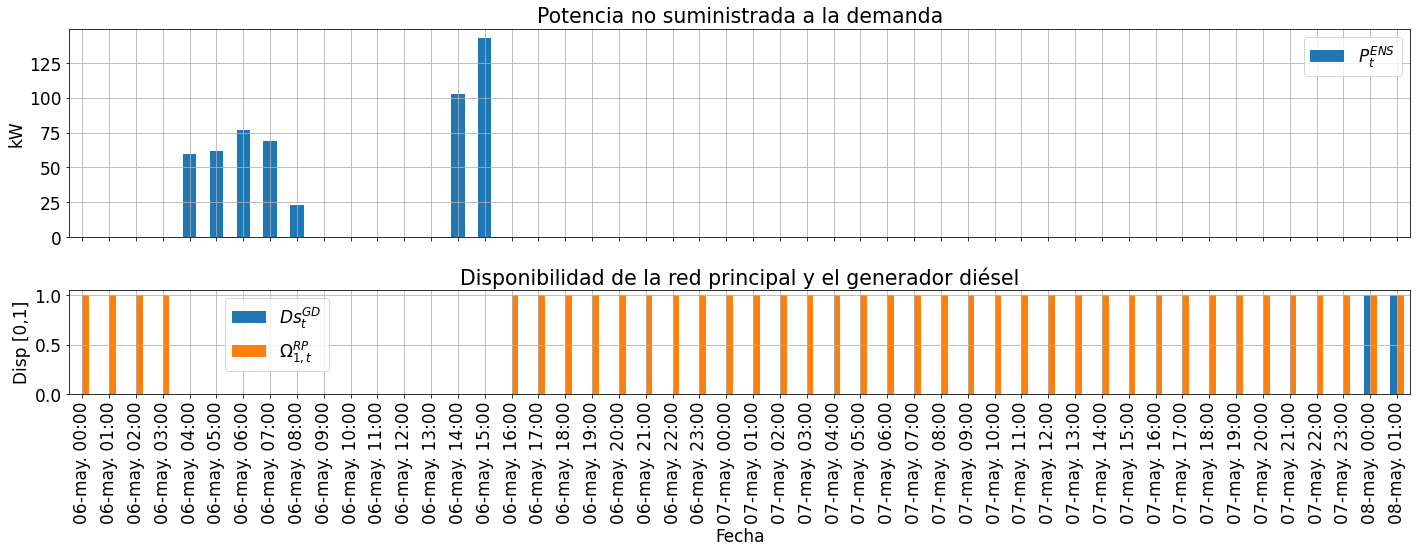

C:\Users\Nicolas\AppData\Local\Temp\ipykernel_16972\3543216317.py:44: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [76]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import locale
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib
matplotlib.rcParams.update({'font.size': 17})
fechas = pd.date_range(start = '01/01/2019 00:00', end='31/12/2019 23:00', freq='1H')
locale.setlocale(locale.LC_ALL, "es_CO.utf8")

fig, ax = plt.subplots(2,1,gridspec_kw={'height_ratios': [2,1]}, figsize=(20,8), sharex=True)

fig_data = pd.DataFrame(index=fechas, data={"diesel":diesel["AV_DIESEL"].to_numpy(),
                                            "scen1":av_scens["scen1"].to_numpy(),
                                            "ENS":pd.read_csv("scen1ENS.csv").dropna().iloc[:,1].to_numpy()})

inicio, final = 3000,3050

fig_data = fig_data.iloc[inicio:final,:]

#fig_data["fechas"] = list(fechas[inicio:final].strftime("%d-%b %H:00"))


fig_data.plot(y=["ENS"],kind='bar',ax = ax[0])
ax[0].grid()
ax[0].set_ylabel("kW")
ax[0].legend([r'$P^{ENS}_{t}$'])
ax[0].set_title("Potencia no suministrada a la demanda")

fig_data.plot(y=["diesel","scen1"],kind='bar',ax = ax[1])
ax[1].set_xticklabels(list(fechas[inicio:final].strftime("%d-%b %H:00")))
ax[1].set_title("Disponibilidad de la red principal y el generador diésel")
ax[1].set_xlabel("Fecha")
ax[1].set_ylabel("Disp [0,1]")
ax[1].legend([r'$Ds^{GD}_{t}$',r'$\Omega^{RP}_{1,t}$'],  bbox_to_anchor=(0.2,1))
ax[1].grid()

fig.tight_layout()


plt.savefig('scen1ENS.pdf', format='pdf', bbox_inches='tight')
plt.show()

fig.show()

In [48]:
pd.read_csv("scen1ENS.csv").dropna()

,ENS[1],0
0,ENS[2],0.0
1,ENS[3],0.0
2,ENS[4],0.0
3,ENS[5],0.0
4,ENS[6],0.0
...,...,...
8754,ENS[8756],0.0
8755,ENS[8757],0.0
8756,ENS[8758],0.0
8757,ENS[8759],0.0
